# Importance sampling

- Sutton 책 챕터 5.5, Example 5.4.
- 블랙잭 예제는 아님.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def true_expectation(v, probs):
    return np.sum(v * probs)

def empirical_expectation(v, probs, N=10000):
    return np.average(np.random.choice(v, size=N, p=probs))

In [3]:
def importance_sampling(target_probs, behavior_probs):
    indices = np.arange(behavior_probs.shape[0])
    index = np.random.choice(indices, size=1, p=behavior_probs)[0]
    ratio = target_probs[index] / behavior_probs[index]
    return ratio, index

# behavior 에서 샘플링해서 target 의 expectation 을 구해보자
def importance_expectation(target_probs, behavior_probs, values, N=10000):
    s = 0.
    ratio_sum = 0.
    for i in range(N):
        ratio, idx = importance_sampling(target_probs, behavior_probs)
        s += ratio * values[idx]
        ratio_sum += ratio
    
    ordinary = s / float(N)
    weighted = 0. if ratio_sum == 0. else s / ratio_sum
    
    return ordinary, weighted

In [4]:
def IE_multi_run(v, pi, b, N, R):
    """ Multi-run importance expectation (expectation via importance sampling) """
    target_true = true_expectation(v, pi)
    ordinaries = []
    weights = []
    for sampling_cnt in range(1, N+1):
        ordinary_mse = 0.
        weighted_mse = 0.
        for _ in range(R):
            ordinary, weighted = importance_expectation(pi, b, v, N=sampling_cnt)
            ordinary_mse += (target_true - ordinary) ** 2
            weighted_mse += (target_true - weighted) ** 2
        # print sampling_cnt, ordinary_mse, weighted_mse
        ordinary_mse /= float(R)
        weighted_mse /= float(R)
        ordinaries.append(ordinary_mse)
        weights.append(weighted_mse)
    
    return ordinaries, weights

In [5]:
def draw_plot(ordinaries, weights, y_max):
    fig = plt.figure(figsize=(12, 6))
    ord_plot = plt.plot(ordinaries, 'go-', ms=5., label='ordinary')
    wei_plot = plt.plot(weights, 'ro-', ms=5., label='weighted')
    plt.legend()
    plt.title('MSE plot')
    plt.ylim((0, y_max))
    plt.show()

## Experiments

In [6]:
def experiment(v, pi, b, N, plot_y_max):
    print "values:", v
    print "pi:", pi
    print "b:", b
    print "sum of probs (pi/b): {} / {}".format(np.sum(pi), np.sum(b))
    print "expectation of pi (true/empirical): {} / {}".format(
        true_expectation(v, pi), empirical_expectation(v, pi))
    print "expectation of b (true/empirical): {} / {}".format(
        true_expectation(v, b), empirical_expectation(v, b))
    print "importance expectation of pi via b (ordinary/weighted): {} / {}".format(
        *importance_expectation(pi, b, v, N=10000))

    ordinaries, weights = IE_multi_run(v, pi, b, N=N, R=100)
    draw_plot(ordinaries, weights, y_max=plot_y_max)

values: [  1 100]
pi: [ 0.9  0.1]
b: [ 0.99  0.01]
sum of probs (pi/b): 1.0 / 1.0
expectation of pi (true/empirical): 10.9 / 11.0683
expectation of b (true/empirical): 1.99 / 1.9108
importance expectation of pi via b (ordinary/weighted): 11.1997272727 / 11.1692656392


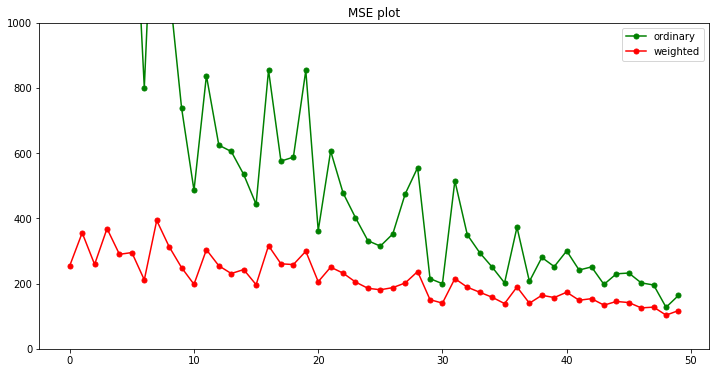

In [7]:
# Ex 1.
v = np.array([1, 100])
pi = np.array([0.9, 0.1])
b = np.array([0.99, 0.01])

experiment(v, pi, b, N=50, plot_y_max=1000)

values: [ 1  2 10 20 40]
pi: [ 0.4  0.4  0.2  0.   0. ]
b: [ 0.1  0.1  0.6  0.1  0.1]
sum of probs (pi/b): 1.0 / 1.0
expectation of pi (true/empirical): 3.2 / 3.2524
expectation of b (true/empirical): 12.3 / 12.1943
importance expectation of pi via b (ordinary/weighted): 3.22333333333 / 3.16343889034


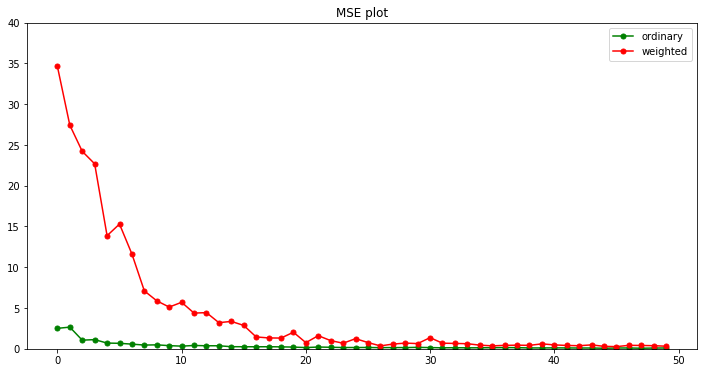

In [8]:
# Ex 2.
v = np.array( [  1,   2,  10,  20,  40])
pi = np.array([0.4, 0.4, 0.2, 0.0, 0.0])
b = np.array( [0.1, 0.1, 0.6, 0.1, 0.1])

experiment(v, pi, b, N=50, plot_y_max=40)

values: [ 1 10]
pi: [ 0.9  0.1]
b: [ 0.1  0.9]
sum of probs (pi/b): 1.0 / 1.0
expectation of pi (true/empirical): 1.9 / 1.9
expectation of b (true/empirical): 9.1 / 9.1423
importance expectation of pi via b (ordinary/weighted): 1.95758888889 / 1.83830342237


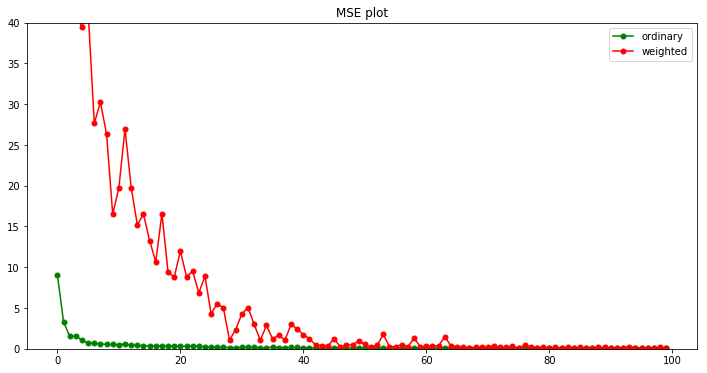

In [9]:
# Ex 3.
v = np.array( [  1, 10])
pi = np.array([0.9, 0.1])
b = np.array( [0.1, 0.9])

experiment(v, pi, b, N=100, plot_y_max=40)

values: [ 1 10]
pi: [ 0.1  0.9]
b: [ 0.9  0.1]
sum of probs (pi/b): 1.0 / 1.0
expectation of pi (true/empirical): 9.1 / 9.0928
expectation of b (true/empirical): 1.9 / 1.8352
importance expectation of pi via b (ordinary/weighted): 8.88426666667 / 9.07792915531


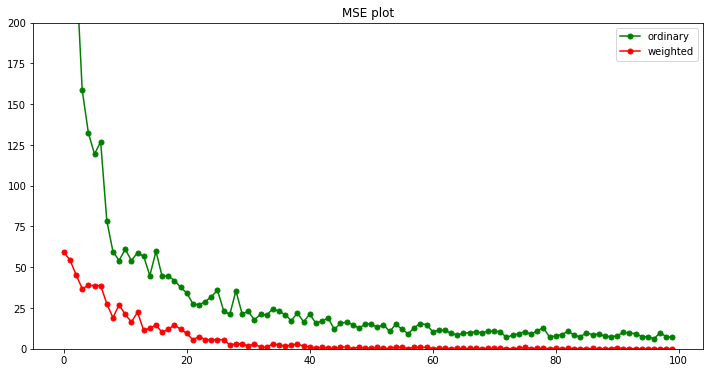

In [10]:
# Ex 4.
v = np.array( [  1, 10])
pi = np.array([0.1, 0.9])
b = np.array( [0.9, 0.1])

experiment(v, pi, b, N=100, plot_y_max=200)

## Discussion

- ordinary 가 더 정확한 경우도 있고 weighted 가 더 정확한 경우도 있음.
    - weighted 가 더 정확한 경우:
        - 더 높은 밸류에 대한 확률이 b 에서 더 낮은 경우. 
        - (ordinary) 하나를 샘플링했다고 치자. Ex 4 에서 10 이 나왔다. 이 경우 importance-sampling ratio 가 9가 되므로 너무 값이 커짐. (90)
    - ordinary 가 더 정확한 경우:
        - 더 높은 밸류에 대한 확률이 b 에서 더 높은 경우.
        - (ordinary) 반대로 Ex 3 에서 10이 나왔다. 이 경우 importance-sampling ratio 가 1/9 가 되므로 값이 작아짐. (10/9)
        - 여기서 10/9 는 오히려 정확한 수치. 따라서 이 경우 ordinary 가 더 정확함.
- 임의의 값에 대해서 평균적으로 좋은 건 weighted 일 듯?